<a href="https://colab.research.google.com/github/RyosukeHanaoka/flask_deploy/blob/main/ResNet50_crp1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.7, 0.2, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/crp>1.0/image_crp1.0_patient'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/images_ra_and_nonra/image_nonra_patient'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 5.6 MB/s eta 0:00:00


In [8]:
batch_size=16 #バッチサイズ(batch size)
epochs = 300
lr = 1e-3#学習率(learning rate: lr)
gamma = 0.7#更新率。デフォルトは0.1。この場合、更新タイミングで学習率が1/10になる
seed = 42#乱数のシード。慣用的に42が使用されることが多い。
def seed_everything(seed):#使用するモジュールにおける乱数のシードを統一し、再現性を確保している。
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)#その他さまざまなtorchに含まれる非決定的な計算過程を決定的なものにして再現性を確保している
# GPUの設定
device = 'cuda'

from torchvision import transforms

# 前処理の定義
train_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    # transforms.RandomVerticalFlip(),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #transforms.RandomHorizontalFlip(),
    # transforms.RandomGrayscale(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

# 画像のパス
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            # 代わりの画像を返す
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0  # または適切なクラスのインデックス
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size // 4,  # 実際のバッチサイズを小さくする
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size // 4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size // 4,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
#pprint(model_names)
model = timm.create_model('resnet50.tv_in1k', pretrained=True, num_classes=2)
#model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss()#正常と異常の２値分類であるためクロスエントロピー法を用いる。
# criterion = nn.HuberLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)#パラメーターはデフォルト値を使用する。学習率は上記に定めたものを使用
# scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=gamma)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

学習ループを設定し、実行していく

In [9]:
import gc
from torchvision.utils import make_grid

# メモリ最適化の環境変数設定
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        # 訓練フェーズ
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        print(
            f"Epoch : {epoch+1} - "
            f"loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f}\n"
        )

        scheduler.step()

    return train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list
# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model
# main関数も更新
def main():
    model = optimize_model_settings()
    train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list = main()

<ipython-input-9-f9a2aeb43fb6>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-9-f9a2aeb43fb6>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7147 - acc: 0.6667 - val_loss : 0.8733 - val_acc: 0.3750 - test_loss : 1.1865 - test_acc: 0.2500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.5433 - acc: 0.7167 - val_loss : 0.5736 - val_acc: 0.7292 - test_loss : 0.5651 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.5140 - acc: 0.7708 - val_loss : 0.4673 - val_acc: 0.7917 - test_loss : 0.5617 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.4507 - acc: 0.7604 - val_loss : 0.3804 - val_acc: 0.8750 - test_loss : 0.4656 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.4612 - acc: 0.7625 - val_loss : 0.4056 - val_acc: 0.8333 - test_loss : 0.5372 - test_acc: 0.7083



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.4539 - acc: 0.7604 - val_loss : 0.5657 - val_acc: 0.7083 - test_loss : 0.6164 - test_acc: 0.6250



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.4414 - acc: 0.8000 - val_loss : 0.3532 - val_acc: 0.8333 - test_loss : 0.4362 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.4176 - acc: 0.8062 - val_loss : 0.3442 - val_acc: 0.8750 - test_loss : 0.4594 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.5147 - acc: 0.7729 - val_loss : 0.6521 - val_acc: 0.6875 - test_loss : 0.6623 - test_acc: 0.6667



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.4549 - acc: 0.7854 - val_loss : 0.4135 - val_acc: 0.7917 - test_loss : 0.3995 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.4631 - acc: 0.7833 - val_loss : 0.4498 - val_acc: 0.7917 - test_loss : 0.3958 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.4258 - acc: 0.8104 - val_loss : 0.5449 - val_acc: 0.7292 - test_loss : 0.5895 - test_acc: 0.6250



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.4321 - acc: 0.8313 - val_loss : 0.3504 - val_acc: 0.8750 - test_loss : 0.3637 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.3957 - acc: 0.8125 - val_loss : 0.3713 - val_acc: 0.8333 - test_loss : 0.4081 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.3862 - acc: 0.8542 - val_loss : 0.3600 - val_acc: 0.8542 - test_loss : 0.3378 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.3842 - acc: 0.8604 - val_loss : 0.4092 - val_acc: 0.8542 - test_loss : 0.4224 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.4089 - acc: 0.8437 - val_loss : 0.4065 - val_acc: 0.8333 - test_loss : 0.4074 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.3986 - acc: 0.7875 - val_loss : 0.3879 - val_acc: 0.7708 - test_loss : 0.3922 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.4047 - acc: 0.8208 - val_loss : 0.4102 - val_acc: 0.8125 - test_loss : 0.4553 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.3617 - acc: 0.8542 - val_loss : 0.4903 - val_acc: 0.7917 - test_loss : 0.4135 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.3469 - acc: 0.8417 - val_loss : 0.2908 - val_acc: 0.8750 - test_loss : 0.2377 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.3254 - acc: 0.8500 - val_loss : 0.2899 - val_acc: 0.8333 - test_loss : 0.2570 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.3635 - acc: 0.8500 - val_loss : 0.3312 - val_acc: 0.8542 - test_loss : 0.2649 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.3414 - acc: 0.8458 - val_loss : 0.3700 - val_acc: 0.8750 - test_loss : 0.3304 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.3396 - acc: 0.8875 - val_loss : 0.3477 - val_acc: 0.7917 - test_loss : 0.2910 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.3268 - acc: 0.8812 - val_loss : 0.6901 - val_acc: 0.7292 - test_loss : 0.4658 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.3907 - acc: 0.7875 - val_loss : 0.3883 - val_acc: 0.8958 - test_loss : 0.3189 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.3167 - acc: 0.8729 - val_loss : 0.3722 - val_acc: 0.8125 - test_loss : 0.3132 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.3404 - acc: 0.8375 - val_loss : 0.4512 - val_acc: 0.7708 - test_loss : 0.3896 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.3207 - acc: 0.8687 - val_loss : 0.7646 - val_acc: 0.6875 - test_loss : 0.6892 - test_acc: 0.7083



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.2794 - acc: 0.8875 - val_loss : 0.3581 - val_acc: 0.8750 - test_loss : 0.3415 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.2902 - acc: 0.8667 - val_loss : 0.5492 - val_acc: 0.7083 - test_loss : 0.4503 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.2558 - acc: 0.8937 - val_loss : 0.3348 - val_acc: 0.8750 - test_loss : 0.3363 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.1918 - acc: 0.9229 - val_loss : 0.3282 - val_acc: 0.8750 - test_loss : 0.3536 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.2593 - acc: 0.8875 - val_loss : 0.3411 - val_acc: 0.8542 - test_loss : 0.3069 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.2372 - acc: 0.9062 - val_loss : 0.3666 - val_acc: 0.9167 - test_loss : 0.3233 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.3189 - acc: 0.9000 - val_loss : 0.4493 - val_acc: 0.7917 - test_loss : 0.3831 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.2840 - acc: 0.8750 - val_loss : 0.4136 - val_acc: 0.7708 - test_loss : 0.4844 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.2525 - acc: 0.9000 - val_loss : 0.2906 - val_acc: 0.8333 - test_loss : 0.2885 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.3135 - acc: 0.8729 - val_loss : 0.3734 - val_acc: 0.8542 - test_loss : 0.3873 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.2976 - acc: 0.8750 - val_loss : 0.4687 - val_acc: 0.7292 - test_loss : 0.5828 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.2473 - acc: 0.8875 - val_loss : 0.4079 - val_acc: 0.8750 - test_loss : 0.4131 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.2722 - acc: 0.9000 - val_loss : 0.3040 - val_acc: 0.8958 - test_loss : 0.3424 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.2942 - acc: 0.9187 - val_loss : 0.3338 - val_acc: 0.8750 - test_loss : 0.3330 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.2453 - acc: 0.9187 - val_loss : 0.2795 - val_acc: 0.9167 - test_loss : 0.3830 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.2495 - acc: 0.9104 - val_loss : 0.3728 - val_acc: 0.8958 - test_loss : 0.4232 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.2324 - acc: 0.8937 - val_loss : 0.3189 - val_acc: 0.9167 - test_loss : 0.3890 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.2098 - acc: 0.8875 - val_loss : 0.3899 - val_acc: 0.7917 - test_loss : 0.2766 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.2074 - acc: 0.9250 - val_loss : 0.3193 - val_acc: 0.9167 - test_loss : 0.2740 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.1448 - acc: 0.9500 - val_loss : 0.3785 - val_acc: 0.8125 - test_loss : 0.3881 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.1563 - acc: 0.9437 - val_loss : 0.3164 - val_acc: 0.8333 - test_loss : 0.3990 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.1587 - acc: 0.9292 - val_loss : 0.2474 - val_acc: 0.9375 - test_loss : 0.2948 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.1102 - acc: 0.9500 - val_loss : 0.2934 - val_acc: 0.8542 - test_loss : 0.3063 - test_acc: 0.9583



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.1218 - acc: 0.9542 - val_loss : 0.3761 - val_acc: 0.9375 - test_loss : 0.4686 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.1222 - acc: 0.9437 - val_loss : 0.4579 - val_acc: 0.8958 - test_loss : 0.4104 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.1459 - acc: 0.9500 - val_loss : 0.2701 - val_acc: 0.8958 - test_loss : 0.4297 - test_acc: 0.7500



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.1302 - acc: 0.9500 - val_loss : 0.2804 - val_acc: 0.8750 - test_loss : 0.4053 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.1878 - acc: 0.9417 - val_loss : 0.3517 - val_acc: 0.9375 - test_loss : 0.4235 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.1722 - acc: 0.9500 - val_loss : 0.4491 - val_acc: 0.7708 - test_loss : 0.5637 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.2283 - acc: 0.9250 - val_loss : 0.2840 - val_acc: 0.8750 - test_loss : 0.3225 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.1979 - acc: 0.9417 - val_loss : 0.2807 - val_acc: 0.9375 - test_loss : 0.3420 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.1547 - acc: 0.9375 - val_loss : 0.3385 - val_acc: 0.8958 - test_loss : 0.3104 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.1417 - acc: 0.9500 - val_loss : 0.2488 - val_acc: 0.9375 - test_loss : 0.2987 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.1147 - acc: 0.9562 - val_loss : 0.2870 - val_acc: 0.9167 - test_loss : 0.3139 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.1517 - acc: 0.9437 - val_loss : 0.3499 - val_acc: 0.8750 - test_loss : 0.3131 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.1482 - acc: 0.9375 - val_loss : 0.2806 - val_acc: 0.9167 - test_loss : 0.2983 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.1127 - acc: 0.9625 - val_loss : 0.2712 - val_acc: 0.9167 - test_loss : 0.3202 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.1449 - acc: 0.9625 - val_loss : 0.2578 - val_acc: 0.9375 - test_loss : 0.3454 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.1563 - acc: 0.9562 - val_loss : 0.2438 - val_acc: 0.9583 - test_loss : 0.3102 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.0695 - acc: 0.9750 - val_loss : 0.3435 - val_acc: 0.8542 - test_loss : 0.2949 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.1165 - acc: 0.9437 - val_loss : 0.3493 - val_acc: 0.8750 - test_loss : 0.2772 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.1201 - acc: 0.9625 - val_loss : 0.4058 - val_acc: 0.8125 - test_loss : 0.3427 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.0857 - acc: 0.9750 - val_loss : 0.3700 - val_acc: 0.8333 - test_loss : 0.2489 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.1295 - acc: 0.9437 - val_loss : 0.3489 - val_acc: 0.8333 - test_loss : 0.2547 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.0875 - acc: 0.9625 - val_loss : 0.3771 - val_acc: 0.8542 - test_loss : 0.2306 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.1717 - acc: 0.9500 - val_loss : 0.3534 - val_acc: 0.8750 - test_loss : 0.2180 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.1568 - acc: 0.9312 - val_loss : 0.4292 - val_acc: 0.8542 - test_loss : 0.3520 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.0863 - acc: 0.9687 - val_loss : 0.3805 - val_acc: 0.8542 - test_loss : 0.4400 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.0468 - acc: 0.9875 - val_loss : 0.2950 - val_acc: 0.8542 - test_loss : 0.2554 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.1405 - acc: 0.9604 - val_loss : 0.4238 - val_acc: 0.8333 - test_loss : 0.4106 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.0883 - acc: 0.9687 - val_loss : 0.5522 - val_acc: 0.7708 - test_loss : 0.5526 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.0927 - acc: 0.9750 - val_loss : 0.4792 - val_acc: 0.7500 - test_loss : 0.6034 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.0803 - acc: 0.9625 - val_loss : 0.3667 - val_acc: 0.9167 - test_loss : 0.4893 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.0800 - acc: 0.9687 - val_loss : 0.4352 - val_acc: 0.8125 - test_loss : 0.5740 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.1102 - acc: 0.9625 - val_loss : 0.3903 - val_acc: 0.8333 - test_loss : 0.5671 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.0496 - acc: 0.9875 - val_loss : 0.3488 - val_acc: 0.8542 - test_loss : 0.4129 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.0578 - acc: 0.9875 - val_loss : 0.4171 - val_acc: 0.7917 - test_loss : 0.4103 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.0708 - acc: 0.9812 - val_loss : 0.3800 - val_acc: 0.8542 - test_loss : 0.3941 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.0920 - acc: 0.9604 - val_loss : 0.3680 - val_acc: 0.8542 - test_loss : 0.3719 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.0884 - acc: 0.9687 - val_loss : 0.4256 - val_acc: 0.8333 - test_loss : 0.4552 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.0579 - acc: 0.9812 - val_loss : 0.3797 - val_acc: 0.8542 - test_loss : 0.4413 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.1024 - acc: 0.9562 - val_loss : 0.4864 - val_acc: 0.8125 - test_loss : 0.5176 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.0867 - acc: 0.9812 - val_loss : 0.4000 - val_acc: 0.7917 - test_loss : 0.4627 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.0452 - acc: 0.9937 - val_loss : 0.4285 - val_acc: 0.8542 - test_loss : 0.4624 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.0529 - acc: 0.9937 - val_loss : 0.4613 - val_acc: 0.8125 - test_loss : 0.4616 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.0327 - acc: 0.9937 - val_loss : 0.4115 - val_acc: 0.8125 - test_loss : 0.4244 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.0680 - acc: 0.9750 - val_loss : 0.4762 - val_acc: 0.8125 - test_loss : 0.4748 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.0370 - acc: 0.9937 - val_loss : 0.5484 - val_acc: 0.8125 - test_loss : 0.4979 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.0317 - acc: 0.9937 - val_loss : 0.5417 - val_acc: 0.8125 - test_loss : 0.4624 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.0522 - acc: 0.9687 - val_loss : 0.5349 - val_acc: 0.8125 - test_loss : 0.4546 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 101 - loss : 0.0182 - acc: 0.9937 - val_loss : 0.5968 - val_acc: 0.7917 - test_loss : 0.5482 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 102 - loss : 0.0672 - acc: 0.9875 - val_loss : 0.5518 - val_acc: 0.8333 - test_loss : 0.4922 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 103 - loss : 0.0664 - acc: 0.9729 - val_loss : 0.5538 - val_acc: 0.8333 - test_loss : 0.4536 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 104 - loss : 0.0446 - acc: 0.9875 - val_loss : 0.5581 - val_acc: 0.8542 - test_loss : 0.4349 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 105 - loss : 0.0805 - acc: 0.9687 - val_loss : 0.5307 - val_acc: 0.8125 - test_loss : 0.3586 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 106 - loss : 0.0289 - acc: 0.9937 - val_loss : 0.4271 - val_acc: 0.8542 - test_loss : 0.3431 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 107 - loss : 0.0559 - acc: 0.9812 - val_loss : 0.5699 - val_acc: 0.7708 - test_loss : 0.4347 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 108 - loss : 0.0810 - acc: 0.9750 - val_loss : 0.4319 - val_acc: 0.8333 - test_loss : 0.3841 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 109 - loss : 0.0373 - acc: 0.9937 - val_loss : 0.4416 - val_acc: 0.8333 - test_loss : 0.4075 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 110 - loss : 0.0304 - acc: 0.9937 - val_loss : 0.4906 - val_acc: 0.8333 - test_loss : 0.4706 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 111 - loss : 0.0306 - acc: 0.9937 - val_loss : 0.4830 - val_acc: 0.8333 - test_loss : 0.4382 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 112 - loss : 0.0375 - acc: 0.9875 - val_loss : 0.5746 - val_acc: 0.8333 - test_loss : 0.5200 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 113 - loss : 0.0561 - acc: 0.9875 - val_loss : 0.4193 - val_acc: 0.8542 - test_loss : 0.3982 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 114 - loss : 0.0355 - acc: 0.9875 - val_loss : 0.5059 - val_acc: 0.8542 - test_loss : 0.4147 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 115 - loss : 0.0798 - acc: 0.9687 - val_loss : 0.4678 - val_acc: 0.8542 - test_loss : 0.3805 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 116 - loss : 0.0550 - acc: 0.9812 - val_loss : 0.4863 - val_acc: 0.8333 - test_loss : 0.3723 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 117 - loss : 0.0620 - acc: 0.9875 - val_loss : 0.5381 - val_acc: 0.8333 - test_loss : 0.4602 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 118 - loss : 0.0337 - acc: 0.9937 - val_loss : 0.5162 - val_acc: 0.8333 - test_loss : 0.4196 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 119 - loss : 0.0322 - acc: 0.9937 - val_loss : 0.4704 - val_acc: 0.8542 - test_loss : 0.3633 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 120 - loss : 0.0426 - acc: 0.9937 - val_loss : 0.4689 - val_acc: 0.8542 - test_loss : 0.3569 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 121 - loss : 0.0573 - acc: 0.9854 - val_loss : 0.5418 - val_acc: 0.8542 - test_loss : 0.3665 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 122 - loss : 0.0229 - acc: 0.9937 - val_loss : 0.6225 - val_acc: 0.7917 - test_loss : 0.3952 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 123 - loss : 0.0231 - acc: 1.0000 - val_loss : 0.5395 - val_acc: 0.8333 - test_loss : 0.3899 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 124 - loss : 0.0427 - acc: 0.9812 - val_loss : 0.4807 - val_acc: 0.8750 - test_loss : 0.3337 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 125 - loss : 0.0324 - acc: 0.9812 - val_loss : 0.5209 - val_acc: 0.8750 - test_loss : 0.3170 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 126 - loss : 0.0317 - acc: 0.9875 - val_loss : 0.5829 - val_acc: 0.8333 - test_loss : 0.3533 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 127 - loss : 0.0478 - acc: 0.9750 - val_loss : 0.5914 - val_acc: 0.8542 - test_loss : 0.3941 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 128 - loss : 0.0748 - acc: 0.9750 - val_loss : 0.5270 - val_acc: 0.8750 - test_loss : 0.3099 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 129 - loss : 0.0663 - acc: 0.9792 - val_loss : 0.4919 - val_acc: 0.8750 - test_loss : 0.2999 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 130 - loss : 0.0224 - acc: 0.9917 - val_loss : 0.5566 - val_acc: 0.8750 - test_loss : 0.3087 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 131 - loss : 0.0238 - acc: 0.9937 - val_loss : 0.6394 - val_acc: 0.7917 - test_loss : 0.3511 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 132 - loss : 0.0138 - acc: 1.0000 - val_loss : 0.5628 - val_acc: 0.8542 - test_loss : 0.2871 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 133 - loss : 0.0318 - acc: 0.9875 - val_loss : 0.5588 - val_acc: 0.8333 - test_loss : 0.2844 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 134 - loss : 0.0494 - acc: 0.9875 - val_loss : 0.5140 - val_acc: 0.8750 - test_loss : 0.2660 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 135 - loss : 0.0426 - acc: 0.9875 - val_loss : 0.4754 - val_acc: 0.8750 - test_loss : 0.2994 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 136 - loss : 0.0200 - acc: 0.9937 - val_loss : 0.4656 - val_acc: 0.8542 - test_loss : 0.2926 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 137 - loss : 0.0156 - acc: 1.0000 - val_loss : 0.4837 - val_acc: 0.8750 - test_loss : 0.3117 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 138 - loss : 0.0212 - acc: 0.9937 - val_loss : 0.5455 - val_acc: 0.8750 - test_loss : 0.2846 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 139 - loss : 0.0210 - acc: 0.9937 - val_loss : 0.6116 - val_acc: 0.8542 - test_loss : 0.3015 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 140 - loss : 0.0149 - acc: 1.0000 - val_loss : 0.5420 - val_acc: 0.8750 - test_loss : 0.2998 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 141 - loss : 0.0228 - acc: 0.9875 - val_loss : 0.5682 - val_acc: 0.8542 - test_loss : 0.2715 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 142 - loss : 0.0425 - acc: 0.9854 - val_loss : 0.5970 - val_acc: 0.8542 - test_loss : 0.3446 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 143 - loss : 0.0465 - acc: 0.9937 - val_loss : 0.5792 - val_acc: 0.8542 - test_loss : 0.2842 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 144 - loss : 0.0301 - acc: 0.9875 - val_loss : 0.5412 - val_acc: 0.8333 - test_loss : 0.3164 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 145 - loss : 0.0199 - acc: 1.0000 - val_loss : 0.5392 - val_acc: 0.8750 - test_loss : 0.2838 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 146 - loss : 0.0168 - acc: 1.0000 - val_loss : 0.5852 - val_acc: 0.8750 - test_loss : 0.3141 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 147 - loss : 0.0223 - acc: 0.9937 - val_loss : 0.5577 - val_acc: 0.8750 - test_loss : 0.2985 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 148 - loss : 0.0395 - acc: 0.9875 - val_loss : 0.5181 - val_acc: 0.8125 - test_loss : 0.2575 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 149 - loss : 0.0266 - acc: 0.9875 - val_loss : 0.5553 - val_acc: 0.8750 - test_loss : 0.2988 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 150 - loss : 0.0328 - acc: 0.9875 - val_loss : 0.5645 - val_acc: 0.8750 - test_loss : 0.2886 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 151 - loss : 0.0347 - acc: 0.9937 - val_loss : 0.5982 - val_acc: 0.8750 - test_loss : 0.2872 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 152 - loss : 0.0271 - acc: 0.9937 - val_loss : 0.6208 - val_acc: 0.8333 - test_loss : 0.3187 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 153 - loss : 0.0246 - acc: 0.9937 - val_loss : 0.6594 - val_acc: 0.7917 - test_loss : 0.3259 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 154 - loss : 0.0483 - acc: 0.9812 - val_loss : 0.5991 - val_acc: 0.8542 - test_loss : 0.3143 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 155 - loss : 0.0238 - acc: 0.9937 - val_loss : 0.5745 - val_acc: 0.8333 - test_loss : 0.3191 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 156 - loss : 0.0660 - acc: 0.9812 - val_loss : 0.6199 - val_acc: 0.8750 - test_loss : 0.3140 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 157 - loss : 0.0345 - acc: 0.9812 - val_loss : 0.6031 - val_acc: 0.8542 - test_loss : 0.3049 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 158 - loss : 0.0606 - acc: 0.9875 - val_loss : 0.5506 - val_acc: 0.8542 - test_loss : 0.2872 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 159 - loss : 0.0428 - acc: 0.9875 - val_loss : 0.5436 - val_acc: 0.8750 - test_loss : 0.3089 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 160 - loss : 0.0254 - acc: 0.9937 - val_loss : 0.5357 - val_acc: 0.8542 - test_loss : 0.3133 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 161 - loss : 0.0162 - acc: 0.9937 - val_loss : 0.5797 - val_acc: 0.8542 - test_loss : 0.3277 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 162 - loss : 0.0223 - acc: 1.0000 - val_loss : 0.5876 - val_acc: 0.8542 - test_loss : 0.3335 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 163 - loss : 0.0224 - acc: 0.9937 - val_loss : 0.6590 - val_acc: 0.8542 - test_loss : 0.3347 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 164 - loss : 0.0320 - acc: 0.9937 - val_loss : 0.6256 - val_acc: 0.8542 - test_loss : 0.3275 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 165 - loss : 0.0106 - acc: 1.0000 - val_loss : 0.6107 - val_acc: 0.8542 - test_loss : 0.3135 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 166 - loss : 0.0253 - acc: 1.0000 - val_loss : 0.5577 - val_acc: 0.8750 - test_loss : 0.3294 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 167 - loss : 0.0228 - acc: 1.0000 - val_loss : 0.5785 - val_acc: 0.8542 - test_loss : 0.3171 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 168 - loss : 0.0370 - acc: 0.9937 - val_loss : 0.5589 - val_acc: 0.8542 - test_loss : 0.3105 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 169 - loss : 0.0447 - acc: 0.9875 - val_loss : 0.5666 - val_acc: 0.8750 - test_loss : 0.3137 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 170 - loss : 0.0114 - acc: 1.0000 - val_loss : 0.6401 - val_acc: 0.8542 - test_loss : 0.3408 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 171 - loss : 0.0560 - acc: 0.9750 - val_loss : 0.6427 - val_acc: 0.8333 - test_loss : 0.3215 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 172 - loss : 0.0126 - acc: 1.0000 - val_loss : 0.5805 - val_acc: 0.8542 - test_loss : 0.3067 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 173 - loss : 0.0132 - acc: 1.0000 - val_loss : 0.6133 - val_acc: 0.8542 - test_loss : 0.3137 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 174 - loss : 0.0147 - acc: 1.0000 - val_loss : 0.6015 - val_acc: 0.8333 - test_loss : 0.2931 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 175 - loss : 0.0303 - acc: 0.9937 - val_loss : 0.5745 - val_acc: 0.8542 - test_loss : 0.2891 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 176 - loss : 0.0266 - acc: 0.9937 - val_loss : 0.6319 - val_acc: 0.8750 - test_loss : 0.3216 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 177 - loss : 0.0559 - acc: 0.9792 - val_loss : 0.5769 - val_acc: 0.8542 - test_loss : 0.2763 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 178 - loss : 0.0088 - acc: 1.0000 - val_loss : 0.5516 - val_acc: 0.8750 - test_loss : 0.2910 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 179 - loss : 0.0154 - acc: 0.9937 - val_loss : 0.6207 - val_acc: 0.8750 - test_loss : 0.3243 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 180 - loss : 0.0365 - acc: 0.9812 - val_loss : 0.5626 - val_acc: 0.8542 - test_loss : 0.3046 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 181 - loss : 0.0486 - acc: 0.9812 - val_loss : 0.6025 - val_acc: 0.8750 - test_loss : 0.3394 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 182 - loss : 0.0130 - acc: 1.0000 - val_loss : 0.6097 - val_acc: 0.8542 - test_loss : 0.3185 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 183 - loss : 0.0215 - acc: 1.0000 - val_loss : 0.6035 - val_acc: 0.8542 - test_loss : 0.2921 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 184 - loss : 0.0238 - acc: 0.9937 - val_loss : 0.6126 - val_acc: 0.8750 - test_loss : 0.3291 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 185 - loss : 0.0186 - acc: 1.0000 - val_loss : 0.6370 - val_acc: 0.8542 - test_loss : 0.3339 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 186 - loss : 0.0136 - acc: 1.0000 - val_loss : 0.6020 - val_acc: 0.8542 - test_loss : 0.3144 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 187 - loss : 0.0608 - acc: 0.9812 - val_loss : 0.6170 - val_acc: 0.8750 - test_loss : 0.3148 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 188 - loss : 0.0393 - acc: 0.9937 - val_loss : 0.6104 - val_acc: 0.8542 - test_loss : 0.3440 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 189 - loss : 0.0258 - acc: 0.9875 - val_loss : 0.5980 - val_acc: 0.8542 - test_loss : 0.3255 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 190 - loss : 0.0374 - acc: 0.9875 - val_loss : 0.6629 - val_acc: 0.8542 - test_loss : 0.3637 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 191 - loss : 0.0246 - acc: 0.9937 - val_loss : 0.5950 - val_acc: 0.8750 - test_loss : 0.3422 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 192 - loss : 0.0250 - acc: 0.9937 - val_loss : 0.5950 - val_acc: 0.8542 - test_loss : 0.3187 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 193 - loss : 0.0315 - acc: 0.9875 - val_loss : 0.6134 - val_acc: 0.8750 - test_loss : 0.3427 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 194 - loss : 0.0109 - acc: 1.0000 - val_loss : 0.6353 - val_acc: 0.8542 - test_loss : 0.3179 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 195 - loss : 0.0841 - acc: 0.9750 - val_loss : 0.6058 - val_acc: 0.8542 - test_loss : 0.2920 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 196 - loss : 0.0137 - acc: 1.0000 - val_loss : 0.6206 - val_acc: 0.8125 - test_loss : 0.3094 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 197 - loss : 0.0461 - acc: 0.9812 - val_loss : 0.6576 - val_acc: 0.8125 - test_loss : 0.3280 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 198 - loss : 0.0189 - acc: 1.0000 - val_loss : 0.6236 - val_acc: 0.8750 - test_loss : 0.3269 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 199 - loss : 0.0267 - acc: 0.9812 - val_loss : 0.5934 - val_acc: 0.8125 - test_loss : 0.3251 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 200 - loss : 0.0268 - acc: 0.9937 - val_loss : 0.6511 - val_acc: 0.8125 - test_loss : 0.3588 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 201 - loss : 0.0212 - acc: 0.9937 - val_loss : 0.6271 - val_acc: 0.8542 - test_loss : 0.3008 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 202 - loss : 0.0244 - acc: 0.9937 - val_loss : 0.5837 - val_acc: 0.8750 - test_loss : 0.3259 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 203 - loss : 0.0226 - acc: 0.9937 - val_loss : 0.6217 - val_acc: 0.8542 - test_loss : 0.3168 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 204 - loss : 0.0303 - acc: 0.9937 - val_loss : 0.6520 - val_acc: 0.8542 - test_loss : 0.3580 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 205 - loss : 0.0307 - acc: 0.9937 - val_loss : 0.6752 - val_acc: 0.8333 - test_loss : 0.3358 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 206 - loss : 0.0154 - acc: 1.0000 - val_loss : 0.6539 - val_acc: 0.8125 - test_loss : 0.3587 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 207 - loss : 0.0705 - acc: 0.9625 - val_loss : 0.6859 - val_acc: 0.8125 - test_loss : 0.3468 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 208 - loss : 0.0315 - acc: 0.9937 - val_loss : 0.6061 - val_acc: 0.8333 - test_loss : 0.3105 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 209 - loss : 0.0185 - acc: 1.0000 - val_loss : 0.6190 - val_acc: 0.8542 - test_loss : 0.3247 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 210 - loss : 0.0508 - acc: 0.9812 - val_loss : 0.6868 - val_acc: 0.8333 - test_loss : 0.3553 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 211 - loss : 0.0426 - acc: 0.9875 - val_loss : 0.5912 - val_acc: 0.8542 - test_loss : 0.3159 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 212 - loss : 0.0389 - acc: 0.9812 - val_loss : 0.6353 - val_acc: 0.8542 - test_loss : 0.3586 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 213 - loss : 0.0298 - acc: 0.9937 - val_loss : 0.6120 - val_acc: 0.8750 - test_loss : 0.3166 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 214 - loss : 0.0279 - acc: 1.0000 - val_loss : 0.6027 - val_acc: 0.8750 - test_loss : 0.3328 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 215 - loss : 0.0157 - acc: 1.0000 - val_loss : 0.5833 - val_acc: 0.8750 - test_loss : 0.3044 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 216 - loss : 0.0221 - acc: 0.9875 - val_loss : 0.5868 - val_acc: 0.8750 - test_loss : 0.3290 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 217 - loss : 0.0198 - acc: 0.9937 - val_loss : 0.6297 - val_acc: 0.8125 - test_loss : 0.3351 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 218 - loss : 0.0179 - acc: 1.0000 - val_loss : 0.6148 - val_acc: 0.8542 - test_loss : 0.3122 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 219 - loss : 0.0303 - acc: 0.9937 - val_loss : 0.6057 - val_acc: 0.8750 - test_loss : 0.3355 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 220 - loss : 0.0261 - acc: 0.9875 - val_loss : 0.6619 - val_acc: 0.8125 - test_loss : 0.3438 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 221 - loss : 0.0224 - acc: 1.0000 - val_loss : 0.6802 - val_acc: 0.8542 - test_loss : 0.3666 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 222 - loss : 0.0221 - acc: 0.9937 - val_loss : 0.6051 - val_acc: 0.8750 - test_loss : 0.3323 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 223 - loss : 0.0198 - acc: 0.9937 - val_loss : 0.5847 - val_acc: 0.8542 - test_loss : 0.2874 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 224 - loss : 0.0532 - acc: 0.9833 - val_loss : 0.5911 - val_acc: 0.8542 - test_loss : 0.3154 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 225 - loss : 0.0111 - acc: 1.0000 - val_loss : 0.5747 - val_acc: 0.8542 - test_loss : 0.3226 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 226 - loss : 0.0472 - acc: 0.9812 - val_loss : 0.6261 - val_acc: 0.8750 - test_loss : 0.3248 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 227 - loss : 0.0382 - acc: 0.9875 - val_loss : 0.6710 - val_acc: 0.8750 - test_loss : 0.3238 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 228 - loss : 0.0227 - acc: 0.9937 - val_loss : 0.6937 - val_acc: 0.7917 - test_loss : 0.3812 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 229 - loss : 0.0168 - acc: 1.0000 - val_loss : 0.6691 - val_acc: 0.8333 - test_loss : 0.3299 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 230 - loss : 0.0797 - acc: 0.9625 - val_loss : 0.6245 - val_acc: 0.8333 - test_loss : 0.3204 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 231 - loss : 0.0174 - acc: 1.0000 - val_loss : 0.6597 - val_acc: 0.8750 - test_loss : 0.3260 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 232 - loss : 0.0186 - acc: 0.9937 - val_loss : 0.6403 - val_acc: 0.8125 - test_loss : 0.3696 - test_acc: 0.7917



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 233 - loss : 0.0669 - acc: 0.9812 - val_loss : 0.6172 - val_acc: 0.8542 - test_loss : 0.3425 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 234 - loss : 0.0115 - acc: 0.9937 - val_loss : 0.6335 - val_acc: 0.8750 - test_loss : 0.3506 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 235 - loss : 0.0162 - acc: 1.0000 - val_loss : 0.5965 - val_acc: 0.8125 - test_loss : 0.3151 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 236 - loss : 0.0247 - acc: 0.9937 - val_loss : 0.6472 - val_acc: 0.8125 - test_loss : 0.3342 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 237 - loss : 0.0270 - acc: 1.0000 - val_loss : 0.6334 - val_acc: 0.8750 - test_loss : 0.3235 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 238 - loss : 0.0221 - acc: 1.0000 - val_loss : 0.6760 - val_acc: 0.8750 - test_loss : 0.3492 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 239 - loss : 0.0364 - acc: 0.9812 - val_loss : 0.6337 - val_acc: 0.8125 - test_loss : 0.3303 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 240 - loss : 0.0278 - acc: 0.9937 - val_loss : 0.6374 - val_acc: 0.8333 - test_loss : 0.3140 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 241 - loss : 0.0153 - acc: 1.0000 - val_loss : 0.6230 - val_acc: 0.8542 - test_loss : 0.3084 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 242 - loss : 0.0231 - acc: 0.9937 - val_loss : 0.6832 - val_acc: 0.8750 - test_loss : 0.3681 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 243 - loss : 0.0243 - acc: 0.9937 - val_loss : 0.6116 - val_acc: 0.8750 - test_loss : 0.2752 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 244 - loss : 0.0303 - acc: 0.9937 - val_loss : 0.5676 - val_acc: 0.8750 - test_loss : 0.3284 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 245 - loss : 0.0240 - acc: 0.9937 - val_loss : 0.6460 - val_acc: 0.8750 - test_loss : 0.3402 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 246 - loss : 0.0345 - acc: 0.9937 - val_loss : 0.6153 - val_acc: 0.8750 - test_loss : 0.3049 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 247 - loss : 0.0504 - acc: 0.9792 - val_loss : 0.6107 - val_acc: 0.8750 - test_loss : 0.3212 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 248 - loss : 0.0083 - acc: 1.0000 - val_loss : 0.6157 - val_acc: 0.8750 - test_loss : 0.3348 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 249 - loss : 0.0144 - acc: 1.0000 - val_loss : 0.6200 - val_acc: 0.8750 - test_loss : 0.3370 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 250 - loss : 0.0332 - acc: 0.9875 - val_loss : 0.6057 - val_acc: 0.8750 - test_loss : 0.3251 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 251 - loss : 0.0432 - acc: 0.9937 - val_loss : 0.6292 - val_acc: 0.8333 - test_loss : 0.3297 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 252 - loss : 0.0162 - acc: 0.9937 - val_loss : 0.6167 - val_acc: 0.8750 - test_loss : 0.3337 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 253 - loss : 0.0122 - acc: 1.0000 - val_loss : 0.5957 - val_acc: 0.8542 - test_loss : 0.2880 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 254 - loss : 0.0397 - acc: 0.9812 - val_loss : 0.5804 - val_acc: 0.8750 - test_loss : 0.3235 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 255 - loss : 0.0264 - acc: 0.9937 - val_loss : 0.6100 - val_acc: 0.8542 - test_loss : 0.3117 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 256 - loss : 0.0201 - acc: 0.9937 - val_loss : 0.6398 - val_acc: 0.8333 - test_loss : 0.3153 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 257 - loss : 0.0188 - acc: 0.9937 - val_loss : 0.5786 - val_acc: 0.8750 - test_loss : 0.3259 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 258 - loss : 0.0330 - acc: 0.9875 - val_loss : 0.5976 - val_acc: 0.8542 - test_loss : 0.3102 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 259 - loss : 0.0341 - acc: 0.9875 - val_loss : 0.6374 - val_acc: 0.8125 - test_loss : 0.2936 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 260 - loss : 0.0503 - acc: 0.9812 - val_loss : 0.5842 - val_acc: 0.8750 - test_loss : 0.3407 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 261 - loss : 0.0390 - acc: 0.9812 - val_loss : 0.5966 - val_acc: 0.8750 - test_loss : 0.3120 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 262 - loss : 0.0191 - acc: 0.9937 - val_loss : 0.5701 - val_acc: 0.8750 - test_loss : 0.3209 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 263 - loss : 0.0429 - acc: 0.9937 - val_loss : 0.5975 - val_acc: 0.8542 - test_loss : 0.3093 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 264 - loss : 0.0317 - acc: 0.9937 - val_loss : 0.5987 - val_acc: 0.8542 - test_loss : 0.3039 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 265 - loss : 0.0323 - acc: 0.9875 - val_loss : 0.6500 - val_acc: 0.8333 - test_loss : 0.3212 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 266 - loss : 0.0204 - acc: 0.9937 - val_loss : 0.6926 - val_acc: 0.8542 - test_loss : 0.3362 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 267 - loss : 0.0290 - acc: 0.9875 - val_loss : 0.5681 - val_acc: 0.8750 - test_loss : 0.3358 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 268 - loss : 0.0101 - acc: 1.0000 - val_loss : 0.6173 - val_acc: 0.8542 - test_loss : 0.3165 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 269 - loss : 0.0157 - acc: 0.9937 - val_loss : 0.6372 - val_acc: 0.8542 - test_loss : 0.3373 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 270 - loss : 0.0303 - acc: 0.9937 - val_loss : 0.5919 - val_acc: 0.8750 - test_loss : 0.3227 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 271 - loss : 0.0383 - acc: 0.9854 - val_loss : 0.5901 - val_acc: 0.8750 - test_loss : 0.3360 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 272 - loss : 0.0217 - acc: 0.9937 - val_loss : 0.5999 - val_acc: 0.8333 - test_loss : 0.3001 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 273 - loss : 0.0386 - acc: 0.9917 - val_loss : 0.5884 - val_acc: 0.8750 - test_loss : 0.3156 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 274 - loss : 0.0215 - acc: 1.0000 - val_loss : 0.6328 - val_acc: 0.8542 - test_loss : 0.3216 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 275 - loss : 0.0119 - acc: 1.0000 - val_loss : 0.5842 - val_acc: 0.8750 - test_loss : 0.3369 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 276 - loss : 0.0369 - acc: 0.9875 - val_loss : 0.5658 - val_acc: 0.8750 - test_loss : 0.3341 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 277 - loss : 0.0296 - acc: 0.9937 - val_loss : 0.5605 - val_acc: 0.8750 - test_loss : 0.2997 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 278 - loss : 0.0216 - acc: 0.9875 - val_loss : 0.6698 - val_acc: 0.8125 - test_loss : 0.3150 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 279 - loss : 0.0299 - acc: 0.9937 - val_loss : 0.6581 - val_acc: 0.8542 - test_loss : 0.3413 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 280 - loss : 0.0282 - acc: 0.9854 - val_loss : 0.6651 - val_acc: 0.8750 - test_loss : 0.3440 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 281 - loss : 0.0671 - acc: 0.9875 - val_loss : 0.6717 - val_acc: 0.8542 - test_loss : 0.3315 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 282 - loss : 0.0113 - acc: 1.0000 - val_loss : 0.6091 - val_acc: 0.8750 - test_loss : 0.3193 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 283 - loss : 0.0176 - acc: 0.9937 - val_loss : 0.6241 - val_acc: 0.8542 - test_loss : 0.3225 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 284 - loss : 0.0132 - acc: 1.0000 - val_loss : 0.6024 - val_acc: 0.8542 - test_loss : 0.3190 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 285 - loss : 0.0171 - acc: 1.0000 - val_loss : 0.6389 - val_acc: 0.8542 - test_loss : 0.3258 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 286 - loss : 0.0338 - acc: 0.9792 - val_loss : 0.6326 - val_acc: 0.8333 - test_loss : 0.3333 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 287 - loss : 0.0381 - acc: 0.9875 - val_loss : 0.5729 - val_acc: 0.8542 - test_loss : 0.3162 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 288 - loss : 0.0180 - acc: 1.0000 - val_loss : 0.6728 - val_acc: 0.8750 - test_loss : 0.3453 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 289 - loss : 0.0172 - acc: 1.0000 - val_loss : 0.6159 - val_acc: 0.8542 - test_loss : 0.3163 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 290 - loss : 0.0152 - acc: 1.0000 - val_loss : 0.5866 - val_acc: 0.8750 - test_loss : 0.2914 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 291 - loss : 0.0180 - acc: 0.9875 - val_loss : 0.6235 - val_acc: 0.8125 - test_loss : 0.3068 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 292 - loss : 0.0391 - acc: 0.9875 - val_loss : 0.6127 - val_acc: 0.8750 - test_loss : 0.2920 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 293 - loss : 0.0198 - acc: 1.0000 - val_loss : 0.6010 - val_acc: 0.8750 - test_loss : 0.3193 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 294 - loss : 0.0249 - acc: 0.9937 - val_loss : 0.6035 - val_acc: 0.8542 - test_loss : 0.2902 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 295 - loss : 0.0137 - acc: 1.0000 - val_loss : 0.5943 - val_acc: 0.8333 - test_loss : 0.2713 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 296 - loss : 0.0487 - acc: 0.9812 - val_loss : 0.6172 - val_acc: 0.8750 - test_loss : 0.3187 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 297 - loss : 0.0447 - acc: 0.9875 - val_loss : 0.6076 - val_acc: 0.8333 - test_loss : 0.3154 - test_acc: 0.9167



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 298 - loss : 0.0333 - acc: 0.9812 - val_loss : 0.6513 - val_acc: 0.8125 - test_loss : 0.3308 - test_acc: 0.8333



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 299 - loss : 0.0184 - acc: 0.9937 - val_loss : 0.6716 - val_acc: 0.8125 - test_loss : 0.3191 - test_acc: 0.8750



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch : 300 - loss : 0.0337 - acc: 0.9937 - val_loss : 0.6491 - val_acc: 0.8542 - test_loss : 0.3215 - test_acc: 0.9167



# 学習結果の可視化

<ipython-input-5-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


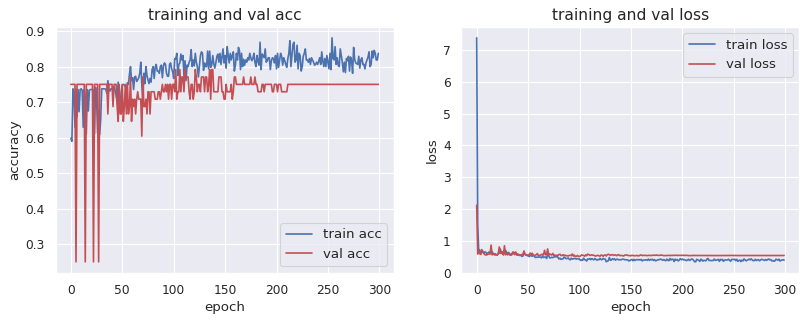

In [5]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

In [6]:
model_save_path = '/content/drive/MyDrive/crp1.0_checkpoint'
torch.save(model.state_dict(), model_save_path)

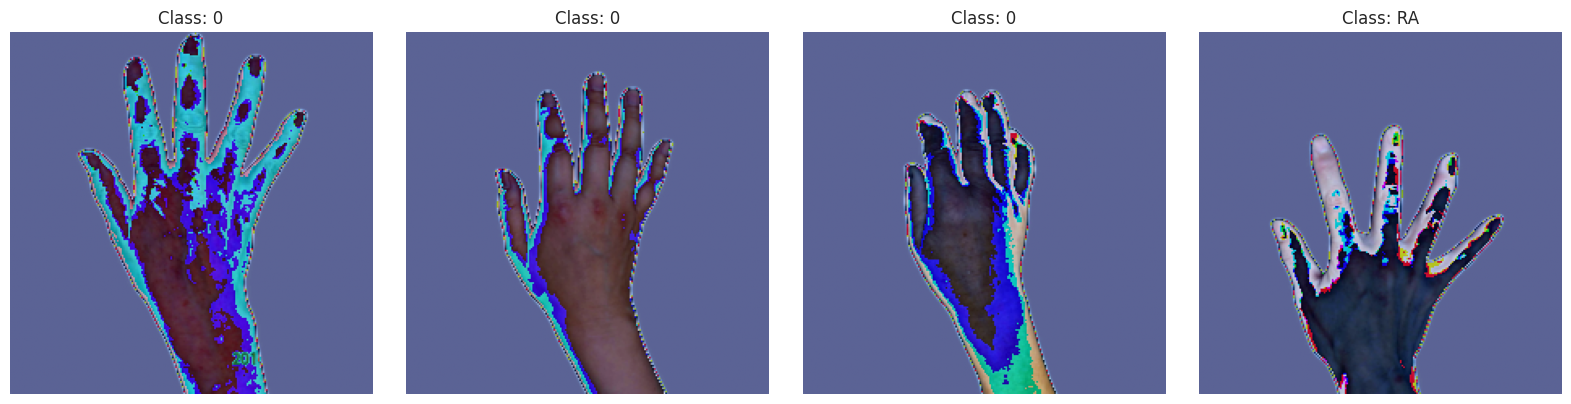

13253

In [7]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # 最後のアテンションブロックを取得
        if hasattr(model, 'blocks'):
            target_layer = model.blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        # 入力をデバイスに移動
        x = x.to(self.device)

        # 予測を実行
        output = self.model(x)
        pred_class = output.argmax(dim=1)

        # 予測クラスに対する勾配を計算
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # 特徴量と勾配の処理
        feature_map = self.feature[:, 1:, :]  # CLSトークンを除外
        gradient_map = self.gradient[:, 1:, :]  # CLS トークンを除外

        # 重みの計算
        weights = gradient_map.mean(dim=2)  # [1, N]

        # CAMの計算
        batch_size = feature_map.shape[0]
        num_patches = feature_map.shape[1]
        patch_size = int(np.sqrt(num_patches))

        cam = torch.mul(feature_map, weights.unsqueeze(-1))
        cam = cam.mean(dim=2)  # [1, N]

        # パッチサイズに変形
        cam = cam.view(batch_size, patch_size, patch_size)

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    # 画像を[0, 255]の範囲に変換
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    # ヒートマップを[0, 255]の範囲に変換してカラーマップを適用
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    # 別のカラーマップを試す（例：COLORMAP_VIRIDISやCOLORMAP_INFERNO）
    #heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_INFERNO)

    # 画像とヒートマップを重ね合わせ
    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# GradCAMのインスタンスを作成
grad_cam = GradCam(model, device)

# テストデータから画像を取得
images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

# ヒートマップの生成と表示
plt.figure(figsize=(20, 4))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        # GradCAMを計算
        heatmap = grad_cam(image.unsqueeze(0))

        # ヒートマップをオーバーレイ
        overlayed = overlay_heatmap_to_image(image, heatmap)

        # 結果を表示
        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {label.item()}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
plt.tight_layout()
plt.show()

# メモリの解放
torch.cuda.empty_cache()
gc.collect()